# Stock Analysis

## Table of Contents

1. [Introduction](#intro)
2. [Load libraries and global variables](#libraries)
3. [Read Data](#read_data)
4. [Data Overview](#data_overview)
5. [Data Cleaning](#data_cleaning)
6. [Feature Engineering](#feature_engineering)
7. [Time Series Analysis](#time_series_analysis)
8. [Corelation Analysis](#corelation)
9. [Data Modelling](#data_modelling)
10. [Model Selection](#model_selection)
11. [Fetch Data](#fetch_data)
12. [Feature Scaling](#feature_scaling)
13. [Train-test timestep data creation](#train_test_split)
14. [Forecasting](#forecasting)
15. [Deep Neural Nets](#dl)
16. [Prediction Analysis](#prediction_analysis)
17. [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

This notebook analyzes content present in the `DIJA 30 Stock Time Series` dataset. It provides detailed insight into the stock trends and also includes a guide to train and fit a LSTM model for stock price prediction.

<a id='libraries'></a>
## Load libraries and set global options

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
pd.options.display.float_format = '{:.2f}'.format
sns.set(rc={'figure.figsize':(20, 20)})

In [64]:
import sys
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display 
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import keras
print("keras version: {}".format(keras.__version__))

import tensorflow as tf
print("tensorflow version: {}".format(tf.__version__))

Python version: 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
pandas version: 0.23.3
matplotlib version: 2.2.2
NumPy version: 1.14.5
SciPy version: 1.1.0
IPython version: 6.4.0
scikit-learn version: 0.19.2
keras version: 2.1.6
tensorflow version: 1.9.0


<a id='read_data'></a>
## Read Data

In [65]:
df = pd.read_csv('../data/all_stocks_2006-01-01_to_2018-01-01.csv')

<a id='data_overview'></a>
## Data Overview

In [66]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


From the website, we find the following information about the columns:

- `Date` - Date for which the price is given
- `Open` - Price of the stock at market open (In USD)
- `High` - Highest price reached in the day
- `Low` - Lowest price reached in the day
- `Close` - Closing price for the day
- `Volume` - Number of shares traded
`- `Name` - the stock's ticker name

Further, the author has mentioned that the data has been collected using the `pandas_datareader` package which fetches data from Google Finance API. This could be a cause for concern as the API has long been deprecated.

In [67]:
df = pd.read_csv('../data/all_stocks_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93612 entries, 0 to 93611
Data columns (total 7 columns):
Date      93612 non-null datetime64[ns]
Open      93587 non-null float64
High      93602 non-null float64
Low       93592 non-null float64
Close     93612 non-null float64
Volume    93612 non-null int64
Name      93612 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.0+ MB


In [69]:
df.Date = pd.to_datetime(df.Date)

In [70]:
df.describe()

,Open,High,Low,Close,Volume
count,93587.00,93602.00,93592.00,93612.00,93612.00
mean,85.62,86.39,84.84,85.64,20156670.14
std,108.15,108.96,107.23,108.12,34421077.71
min,6.75,7.17,0.00,6.66,0.00
25%,33.95,34.29,33.60,33.96,5040180.50
50%,60.04,60.63,59.49,60.05,9701141.50
75%,94.00,94.74,93.25,94.01,20752221.50
max,1204.88,1213.41,1191.15,1195.83,843264044.00


The dataset has some missing values. We will analyze this and see how to fix it.

In [71]:
df.isnull().sum()

Date       0
Open      25
High      10
Low       20
Close      0
Volume     0
Name       0
dtype: int64

The `Open` column has the maximum number of null values. Let's find the rows for which the values are missing.

In [72]:
df[df.Open.isnull()]

,Date,Open,High,Low,Close,Volume,Name
2913,2017-07-31,nan,201.66,nan,201.17,1833625,MMM
5933,2017-07-31,nan,85.70,nan,85.23,3079797,AXP
11972,2017-07-31,nan,nan,nan,242.46,5777271,BA
14992,2017-07-31,nan,nan,nan,113.95,4486013,CAT
18012,2017-07-31,nan,110.00,nan,109.19,7561205,CVX
24051,2017-07-31,nan,nan,45.79,45.84,13622891,KO
25815,2012-08-01,nan,nan,nan,49.14,0,DIS
27071,2017-07-31,nan,110.14,nan,109.93,6815349,DIS
30091,2017-07-31,nan,80.39,nan,80.04,12820175,XOM
33111,2017-07-31,nan,25.69,nan,25.61,30616287,GE


Interesting! The data is missing only for 31 July, 2017. This could be because:
- The API had an unexpected error while fetching the data.
- The data for this day does not exist in the source.

Let's check the number of `business days` for which the records as missing.

In [73]:
rng = pd.date_range(start='2006-01-01', end='2018-01-01', freq='B')
rng[~rng.isin(df.Date.unique())]

DatetimeIndex(['2006-01-02', '2006-01-16', '2006-02-20', '2006-04-14',
               '2006-05-29', '2006-07-04', '2006-09-04', '2006-11-23',
               '2006-12-25', '2007-01-01',
               ...
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-04-14',
               '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-23',
               '2017-12-25', '2018-01-01'],
              dtype='datetime64[ns]', length=111, freq=None)

There are about 111 days for which the stock price data is missing. This could lead to potential problems with the analysis.

In [74]:
df.groupby('Name').count().sort_values('Date', ascending=False)['Date']

Name
JNJ      3020
JPM      3020
WMT      3020
VZ       3020
UTX      3020
UNH      3020
TRV      3020
PG       3020
PFE      3020
NKE      3020
MMM      3020
MCD      3020
KO       3020
XOM      3020
GE       3020
IBM      3020
HD       3020
GS       3020
AXP      3020
BA       3020
CAT      3020
DIS      3020
CVX      3020
CSCO     3019
AMZN     3019
INTC     3019
AAPL     3019
MSFT     3019
MRK      3019
GOOGL    3019
AABA     3019
Name: Date, dtype: int64

In [75]:
gdf = df[df.Name == 'AABA']
cdf = df[df.Name == 'CAT']

In [76]:
cdf[~cdf.Date.isin(gdf.Date)]

,Date,Open,High,Low,Close,Volume,Name
13147,2010-04-01,63.29,64.20,63.29,63.99,7830447,CAT


Some of the companies(Google, Microsoft, etc.) don't have an entry for the date 2010-04-01.

Let's check if all the listed companies have an entry on each date.

In [77]:
# Total number of companies
df.Name.unique().size

31

In [78]:
df.groupby('Date').Name.unique().apply(len)

Date
2006-01-03    31
2006-01-04    31
2006-01-05    31
2006-01-06    31
2006-01-09    31
2006-01-10    31
2006-01-11    31
2006-01-12    31
2006-01-13    31
2006-01-17    31
2006-01-18    31
2006-01-19    31
2006-01-20    31
2006-01-23    31
2006-01-24    31
2006-01-25    31
2006-01-26    31
2006-01-27    31
2006-01-30    31
2006-01-31    31
2006-02-01    31
2006-02-02    31
2006-02-03    31
2006-02-06    31
2006-02-07    31
2006-02-08    31
2006-02-09    31
2006-02-10    31
2006-02-13    31
2006-02-14    31
              ..
2017-11-16    31
2017-11-17    31
2017-11-20    31
2017-11-21    31
2017-11-22    31
2017-11-24    31
2017-11-27    31
2017-11-28    31
2017-11-29    31
2017-11-30    31
2017-12-01    31
2017-12-04    31
2017-12-05    31
2017-12-06    31
2017-12-07    31
2017-12-08    31
2017-12-11    31
2017-12-12    31
2017-12-13    31
2017-12-14    31
2017-12-15    31
2017-12-18    31
2017-12-19    31
2017-12-20    31
2017-12-21    31
2017-12-22    31
2017-12-26    31
2017-12-2

This confirms that each company had a stock price entry on each day.

<a id='data_cleaning'></a>
## Data Cleaning

Let us first fill in the null values on date 31 july, 2017 with the values from the previous day(i.e 28th July, 2017)

In [79]:
df.set_index('Date', inplace=True)

#Backfill `Open` column
values = np.where(df['2017-07-31']['Open'].isnull(), df['2017-07-28']['Open'], df['2017-07-31']['Open'])
df['2017-07-31']= df['2017-07-31'].assign(Open=values.tolist())

values = np.where(df['2017-07-31']['Close'].isnull(), df['2017-07-28']['Close'], df['2017-07-31']['Close'])
df['2017-07-31']= df['2017-07-31'].assign(Close=values.tolist())

values = np.where(df['2017-07-31']['High'].isnull(), df['2017-07-28']['High'], df['2017-07-31']['High'])
df['2017-07-31']= df['2017-07-31'].assign(High=values.tolist())

values = np.where(df['2017-07-31']['Low'].isnull(), df['2017-07-28']['Low'], df['2017-07-31']['Low'])
df['2017-07-31']= df['2017-07-31'].assign(Low=values.tolist())

df.reset_index(inplace=True)


In [80]:
df[df.Date == '2017-07-31']

,Date,Open,High,Low,Close,Volume,Name
2913,2017-07-31,200.79,201.66,198.69,201.17,1833625,MMM
5933,2017-07-31,83.88,85.70,83.62,85.23,3079797,AXP
8952,2017-07-31,149.90,150.33,148.13,148.73,19845920,AAPL
11972,2017-07-31,240.82,242.00,238.55,242.46,5777271,BA
14992,2017-07-31,114.45,114.90,113.48,113.95,4486013,CAT
18012,2017-07-31,106.71,110.00,106.36,109.19,7561205,CVX
21031,2017-07-31,31.54,31.59,31.37,31.45,19256428,CSCO
24051,2017-07-31,46.00,46.12,45.79,45.84,13622891,KO
27071,2017-07-31,109.98,110.14,109.66,109.93,6815349,DIS
30091,2017-07-31,79.65,80.39,78.27,80.04,12820175,XOM


We can confirm that the backfill has worked as expected.

Simlarly, we noticed that 8 of the 31 stocks have missing data on 1st April, 2014. As done before, we will use the stock prices of the previous day to fill the data.

In [81]:
missing_data_stocks = ['CSCO','AMZN','INTC','AAPL','MSFT','MRK','GOOGL', 'AABA']

In [82]:
columns = df.columns.values

In [83]:
for stock in missing_data_stocks:
    tdf = df[(df.Name == stock) & (df.Date == '2014-03-28')].copy()
    tdf.Date = '2014-04-01'
    pd.concat([df, tdf])
print("Complete")

Complete


Let's check if the backfill worked as expected.

In [84]:
df[(df.Name == 'CSCO') & (df.Date == '2014-04-01')]

,Date,Open,High,Low,Close,Volume,Name
20192,2014-04-01,22.33,23.31,22.30,23.10,80113826,CSCO


Awesome! The backfill has worked for that particular day

Finally, there is just one more null record. We will drop that record.

In [85]:
df[df.Open.isnull()]

,Date,Open,High,Low,Close,Volume,Name
25815,2012-08-01,nan,nan,nan,49.14,0,DIS


In [86]:
df = df[~((df.Date == '2012-08-01') & (df.Name == 'DIS'))]

Let's perform a quick sanity check for null values again.

In [87]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

We have dealt with all the null values in the dataset.

<a id='feature_engineering'></a>
## Feature Engineering 

Since we have four values of stock price for each day, let's create a feature called `Price` which is the average of all these values.

In [88]:
values = (df['High'] + df['Low'] + df['Open'] + df['Close'])/4
df = df.assign(Price=values)

In [89]:
df.head()

,Date,Open,High,Low,Close,Volume,Name,Price
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM,78.36
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM,78.98
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM,78.15
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM,78.45
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM,78.95


In [90]:
df.Price.describe()

count   93611.00
mean       85.63
std       108.11
min         6.73
25%        33.95
50%        60.07
75%        94.00
max      1200.76
Name: Price, dtype: float64

We can see that 75% of the stocks have a price of under 94$, indicating that the stock market is mostly dominated by the bigger companies.

Let's go one step further and compute the daily growth of the stock prices compared to day 1 of the prices(i.e compute cumalative compound growth)

In [91]:
stock_names = df.Name.unique()

In [92]:
day_prices = df[df.Date == df.Date.min()].Price

In [93]:
price_mapping = {n : c for n, c in zip(stock_names, day_prices)}

In [94]:
base_mapping = np.array(list(map(lambda x : price_mapping[x], df['Name'].values)))

In [95]:
df['Growth'] = df['Price'] / base_mapping - 1

In [96]:
df.Growth.describe()

count   93611.00
mean        0.79
std         1.91
min        -0.81
25%         0.04
50%         0.34
75%         0.82
max        24.39
Name: Growth, dtype: float64

**Inferences**

Wow! The worst performing company had a decline of 81% in their shares compared to their first ever opening price and the best company had a whopping 2439% increase in their share price. (_Hint_: EC2 instances)

<a id='time_series_analysis'></a>
## Time Series Analysis

Let's find out the top 5 best and worst performing stocks!

In [97]:
sample_dates = pd.date_range(start='2006-01-01', end='2018-01-01', freq='B')

In [98]:
year_end_dates = sample_dates[sample_dates.is_year_end]

In [99]:
year_end_dates

DatetimeIndex(['2006-12-29', '2007-12-31', '2008-12-31', '2009-12-31',
               '2010-12-31', '2011-12-30', '2012-12-31', '2013-12-31',
               '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29'],
              dtype='datetime64[ns]', freq=None)

In [100]:
worst_stocks = df[df.Date == df.Date.max()].sort_values('Growth').head(5)

In [101]:
best_stocks = df[df.Date == df.Date.max()].sort_values('Growth', ascending=False).head(5)

In [102]:
ws = worst_stocks.Name.values

In [103]:
bs = best_stocks.Name.values

In [104]:
tdf = df.copy()

In [105]:
tdf = df.set_index('Date')

Name
AABA    AxesSubplot(0.125,0.2;0.775x0.68)
GE      AxesSubplot(0.125,0.2;0.775x0.68)
PFE     AxesSubplot(0.125,0.2;0.775x0.68)
PG      AxesSubplot(0.125,0.2;0.775x0.68)
XOM     AxesSubplot(0.125,0.2;0.775x0.68)
Name: Growth, dtype: object

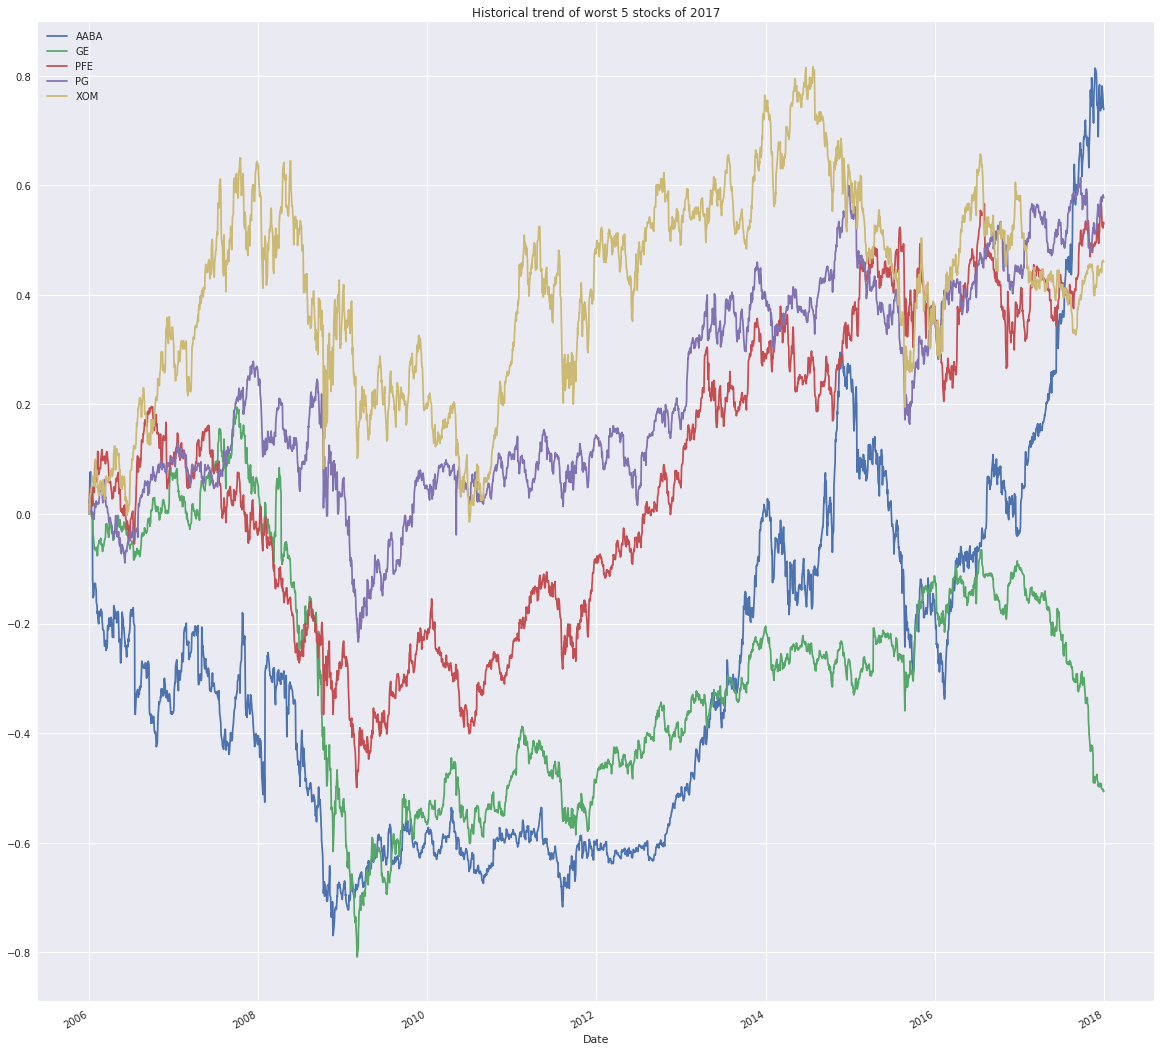

In [106]:
tdf[tdf.Name.isin(ws)].groupby('Name').Growth.plot(title='Historical trend of worst 5 stocks of 2017', legend=True)

Name
AAPL     AxesSubplot(0.125,0.2;0.775x0.68)
AMZN     AxesSubplot(0.125,0.2;0.775x0.68)
GOOGL    AxesSubplot(0.125,0.2;0.775x0.68)
MCD      AxesSubplot(0.125,0.2;0.775x0.68)
NKE      AxesSubplot(0.125,0.2;0.775x0.68)
Name: Growth, dtype: object

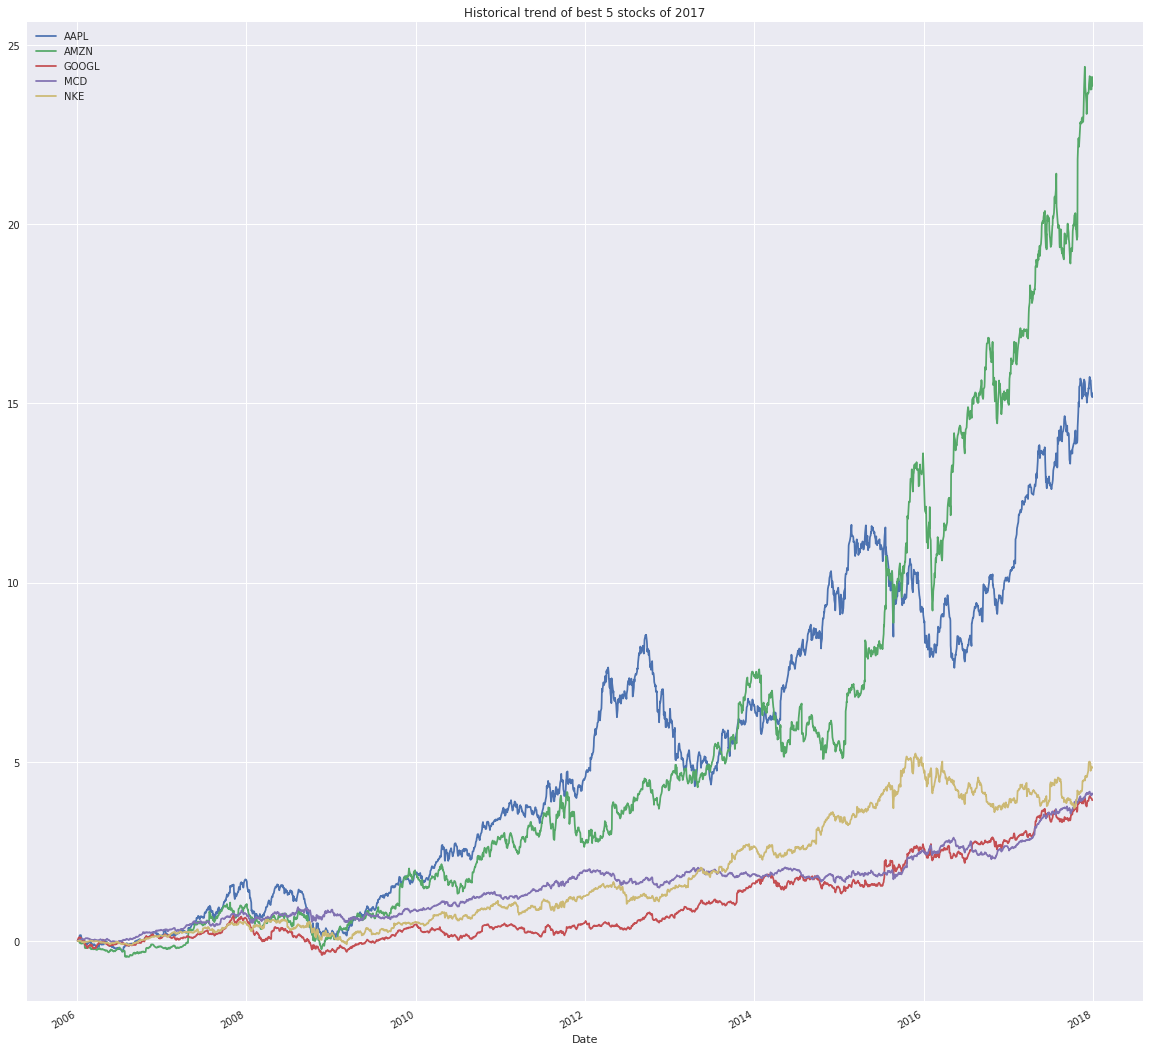

In [107]:
tdf[tdf.Name.isin(bs)].groupby('Name').Growth.plot(title='Historical trend of best 5 stocks of 2017', legend=True)

In [108]:
worst_stocks

,Date,Open,High,Low,Close,Volume,Name,Price,Growth
33217,2017-12-29,17.27,17.53,17.27,17.45,76149513,GE,17.38,-0.51
30197,2017-12-29,84.00,84.20,83.64,83.64,8523411,XOM,83.87,0.46
66434,2017-12-29,36.23,36.49,36.22,36.22,11421487,PFE,36.29,0.53
69454,2017-12-29,92.24,92.46,91.88,91.88,4346675,PG,92.11,0.58
93611,2017-12-29,69.79,70.13,69.43,69.85,6613070,AABA,69.80,0.74


In [109]:
best_stocks

,Date,Open,High,Low,Close,Volume,Name,Price,Growth
90592,2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN,1175.83,23.87
9058,2017-12-29,170.52,170.59,169.22,169.23,25999922,AAPL,169.89,15.17
63414,2017-12-29,63.21,63.37,62.55,62.55,5222115,NKE,62.92,4.83
54356,2017-12-29,172.98,172.98,171.92,172.12,2201771,MCD,172.50,4.10
87573,2017-12-29,1055.49,1058.05,1052.70,1053.40,1180340,GOOGL,1054.91,3.93


** Question: How much would an investment of 1USD in Google in 2006 increase by in 2017?**

According to the above information, an investment of 1 USD in Google in 2006 would have increased the amount to 393USD in 2017. However, the same investment in General Electric Co would have decreased the amount of 0.49USD.
This information could help us create an ideal portfolio of stocks to maximize profit.

<a id='corelation'></a>
## Corelation Analysis

Let us now try to find some corelation between the growth vs time of each stock in the dataset

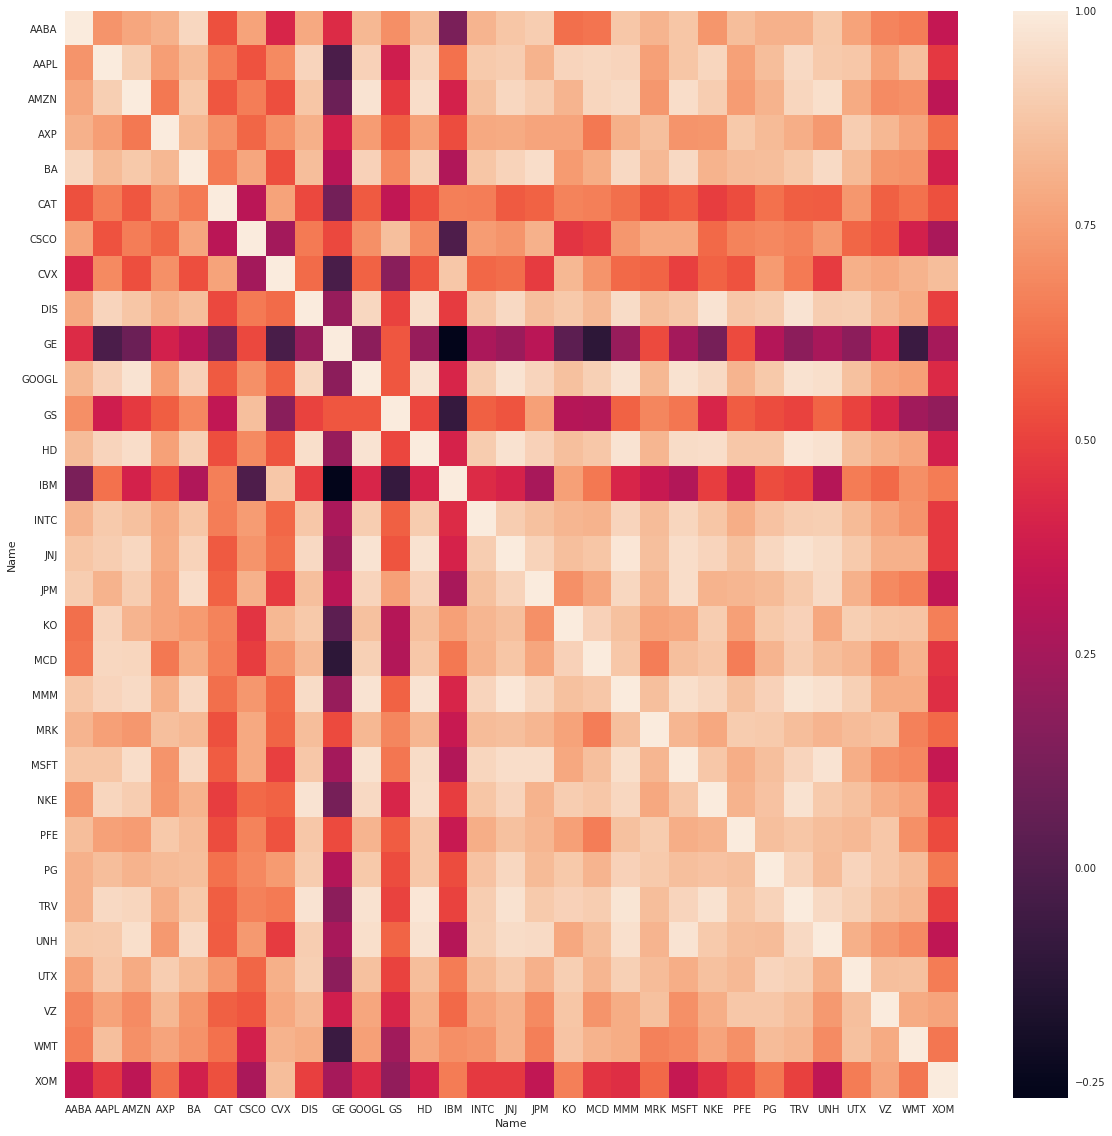

In [110]:
corr = df.pivot('Date', 'Name', 'Growth').corr()
sns.heatmap(corr)

Although we can see some positive and negative corelations, the graph above is very dense. Let's us just focus on high positive and high negative corelations.

In [111]:
def unique_corelations(indices):
    mapping = {}
    for record in indices:
        (stock_a, stock_b) = record
        value_list = mapping.get(stock_a)
        if value_list:
            if stock_b not in value_list:
                value_list.append(stock_b)
                mapping.update({stock_a: value_list})
        else:
            mapping.update({stock_a: [stock_b]})

    return mapping

def filter_corelations_positive(corr, threshold=0.9):
    indices = np.where(corr > threshold)
    indices = [(corr.index[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
    mapping = unique_corelations(indices)
    return mapping
    
def filter_corelations_negative(corr, threshold=-0.8):
    indices = np.where(corr < threshold)
    indices = [(corr.index[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
    mapping = unique_corelations(indices)
    return mapping

In [112]:
filter_corelations_positive(corr, threshold=0.95)

{'AMZN': ['GOOGL', 'HD', 'MSFT', 'UNH'],
 'BA': ['JPM'],
 'DIS': ['HD', 'NKE', 'TRV'],
 'GOOGL': ['HD', 'JNJ', 'MMM', 'MSFT', 'TRV', 'UNH'],
 'HD': ['JNJ', 'MMM', 'NKE', 'TRV', 'UNH'],
 'JNJ': ['MMM', 'MSFT', 'TRV'],
 'JPM': ['MSFT'],
 'MMM': ['MSFT', 'TRV', 'UNH'],
 'MSFT': ['UNH'],
 'NKE': ['TRV']}

In [113]:
filter_corelations_negative(corr, -0.1)

{'GE': ['IBM', 'MCD']}

From the above results, we can note the following:-
- There is a **Strong Positive** corelation in the stock growth of GOOGL with MSFT, NKE, etc.
- There is a **Weak Negative** corelation in the stock growth of GE with IBM and MCD.

Let us try to forecast the prices of the Google Stock(GOOGL) and measure how close we came to the actual value.

<a id='data_modelling'></a>
## Data Modelling

In [114]:
google_df = df[df.Name.isin(['GOOGL', 'GE', 'XOM', 'AMZN', 'AAPL'])]
google_df.head()


,Date,Open,High,Low,Close,Volume,Name,Price,Growth
6040,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL,10.50,0.00
6041,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL,10.73,0.02
6042,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL,10.64,0.01
6043,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL,10.81,0.03
6044,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL,10.92,0.04


In [115]:
google_df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name', 'Price',
       'Growth'],
      dtype='object')

In [116]:
gdf = google_df[['Date', 'Name', 'Price']].pivot(index='Date', columns='Name').sort_values('Date')
#gdf['Date'] = gdf.index

In [117]:
gdf.columns


MultiIndex(levels=[['Price'], ['AAPL', 'AMZN', 'GE', 'GOOGL', 'XOM']],
           labels=[[0, 0, 0, 0, 0], [0, 1, 2, 3, 4]],
           names=[None, 'Name'])

In [118]:
gdf.columns = ['AAPL', 'AMZN', 'GE', 'GOOGL', 'XOM']

In [119]:
gdf = gdf.reset_index()

In [120]:
gdf.head()

,Date,AAPL,AMZN,GE,GOOGL,XOM
0,2006-01-03,10.50,47.29,35.17,214.17,57.45
1,2006-01-04,10.73,47.29,35.29,222.45,58.52
2,2006-01-05,10.64,47.53,35.24,224.01,58.38
3,2006-01-06,10.81,47.94,35.39,231.01,59.13
4,2006-01-09,10.92,46.78,35.36,233.69,59.59


In [121]:
gdf = gdf.dropna()

<a id='model_selection'></a>
## Model Selection

As this is a time-series problem, we can use one of the following models to solve it:
- ARIMA/ARMA: Auto-Regressive Moving Average models are a class of model that captures a suite of different standard temporal structures in time series data.
- LSTM: Long-Short-Term_memory networks are a form of Recurrent Neural Networks. Few advantages of neural nets are:
    - Neural networks can model any non-linear function
    - Neural networks give good results without much parameter tuning


Hence, We will choose LSTM's as our model for forecasting stock prices.

We will try to predict the `Price` of the Google based on the previous 60 values(i.e stock prices on the previous 30 days) 

<a id='fetch_data'></a>
## Fetch Data

We will only use the `Price` column to forecast the future stock price for simplicity. We will ignore all of the other columns.

In [125]:
training_set = gdf[gdf.Date.dt.year != 2017][['GOOGL', 'AAPL', 'AMZN', 'GE', 'XOM']].values

In [126]:
test_set = gdf[gdf.Date.dt.year == 2017][['GOOGL', 'AAPL', 'AMZN', 'GE', 'XOM']].values

In [127]:
training_set, test_set

(array([[214.1675,  10.505 ,  47.2875,  35.1675,  57.445 ],
        [222.45  ,  10.7325,  47.2875,  35.2925,  58.5175],
        [224.01  ,  10.64  ,  47.53  ,  35.2375,  58.385 ],
        ...,
        [808.4175, 117.125 , 774.72  ,  31.795 ,  90.5875],
        [802.275 , 116.6725, 767.95  ,  31.7575,  90.27  ],
        [797.14  , 116.275 , 758.005 ,  31.635 ,  90.25  ]]),
 array([[ 804.24  ,  115.76  ,  754.5125,   31.65  ,   90.83  ],
        [ 808.8   ,  116.0325,  757.3625,   31.725 ,   90.4775],
        [ 810.045 ,  116.3   ,  771.165 ,   31.5375,   89.37  ],
        ...,
        [1063.3625,  170.2975, 1181.2675,   17.445 ,   83.9325],
        [1059.105 ,  171.1025, 1187.395 ,   17.34  ,   83.9625],
        [1054.91  ,  169.89  , 1175.83  ,   17.38  ,   83.87  ]]))

In [128]:
print("Training set size: ",training_set.shape)
print("Test set size: ", test_set.shape)

Training set size:  (2768, 5)
Test set size:  (251, 5)


<a id='Crazy variation 1'></a>
## Crazy Variation 1

Let's see if we can make a better job incorporating more stocks, let's add to the input the top two and the bottom two stocks as part of the training set.

<a id='feature_scaling'></a>
## Feature Scaling

As the amount of stock prices vary by a huge margin, we will scale the prices to be in the 0-1 range

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler()

In [131]:
training_set_scaled = scaler.fit_transform(training_set)
test_set_scaled = scaler.transform(test_set)

<a id='train_test_split'></a>
## Train and Test timestep data creation

For training, we will use previous 30 stock values to predict the stock price at time t. For this, we have to create our training and test set.

In [132]:
def create_train_data(training_set_scaled):
    X_train, y_train = [], []
    for i in range(30, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-30: i])
        y_train.append(training_set_scaled[i,0])
    # Converting list to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [133]:
training_set_scaled

array([[0.11927526, 0.02507943, 0.02591824, 0.80572278, 0.01795623],
       [0.13105909, 0.02689794, 0.02591824, 0.80926411, 0.04041462],
       [0.13327856, 0.02615855, 0.02621499, 0.80770593, 0.03764004],
       ...,
       [0.96473743, 0.87734058, 0.91608693, 0.71017777, 0.71196733],
       [0.95599826, 0.87372355, 0.90780239, 0.70911538, 0.70531881],
       [0.9486925 , 0.87054615, 0.89563257, 0.70564488, 0.70490001]])

In [134]:
training_set_scaled[30:34]

array([[0.05800859, 0.01898443, 0.01543408, 0.75706495, 0.06397236],
       [0.06800333, 0.02132252, 0.01618972, 0.75387775, 0.07098733],
       [0.07703772, 0.0213425 , 0.01590215, 0.75748991, 0.08093393],
       [0.0765611 , 0.02078296, 0.01536984, 0.75805652, 0.09088054]])

In [135]:
X_train, y_train = create_train_data(training_set_scaled)

In [136]:
scaler2 = MinMaxScaler()
dummy = scaler2.fit_transform()

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [137]:
X_train.shape, y_train.shape

((2738, 30, 5), (2738,))

Similarly, we'll create our test data set. 

In [139]:
X_test, y_test = create_train_data(test_set_scaled)

In [140]:
X_test.shape, y_test.shape

((221, 30, 5), (221,))

<a id='forecasting'></a>
## Forecasting

Let us first start with a very simple model. We will use a single LSTM layer.

In [157]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [158]:
def create_simple_model():
    model = Sequential()
    model.add(LSTM(units = 50, 
                   return_sequences = False, 
                   input_shape = (X_train.shape[1], 5)))
    model.add(Dense(units = 1))
    return model

We now need to pick the optimizer for our model and a function to measure how well the model is doing i.e loss. We will pick RMSE as the loss function and Sigmoid Gradient Descent(SGD) as our optimizer with default learning rate(i.e 0.01)

In [159]:
def compile_and_run(model, epochs=40, batch_size=64):
    model.compile(metrics=['accuracy'], optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=3)
    return history

In [160]:
def plot_metrics(history):
    metrics_df = pd.DataFrame(data={"loss": history.history['loss']})
    metrics_df.plot()

In [161]:
simple_model = create_simple_model()
history = compile_and_run(simple_model, epochs=30)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


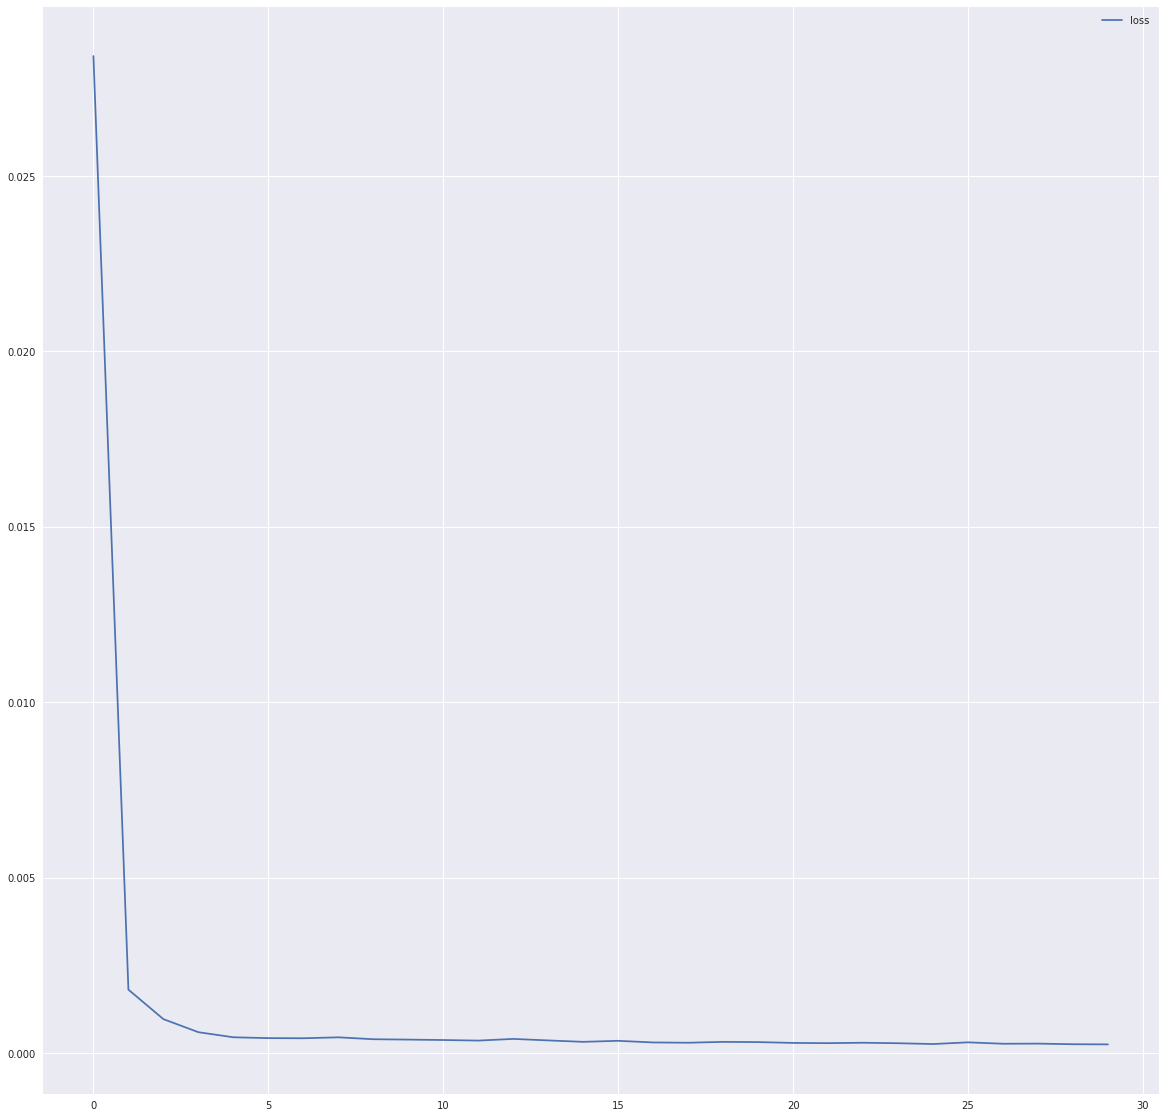

In [162]:
plot_metrics(history)

Let us now use the model on the test set.

In [163]:
def scale_back_y(y, scaler):
    return y / scaler.scale_[0] + scaler.data_min_[0]
     

In [164]:
def make_predictions(X_test, model, scaler):
    y_pred = model.predict(X_test)
    final_predictions = scale_back_y(y_pred, scaler)
    fp = final_predictions.reshape(final_predictions.shape[0])
    ap = test_set[30:,0]
    pdf = pd.DataFrame(data={'Actual': ap, 'Predicted': fp})
    ax = pdf.plot()

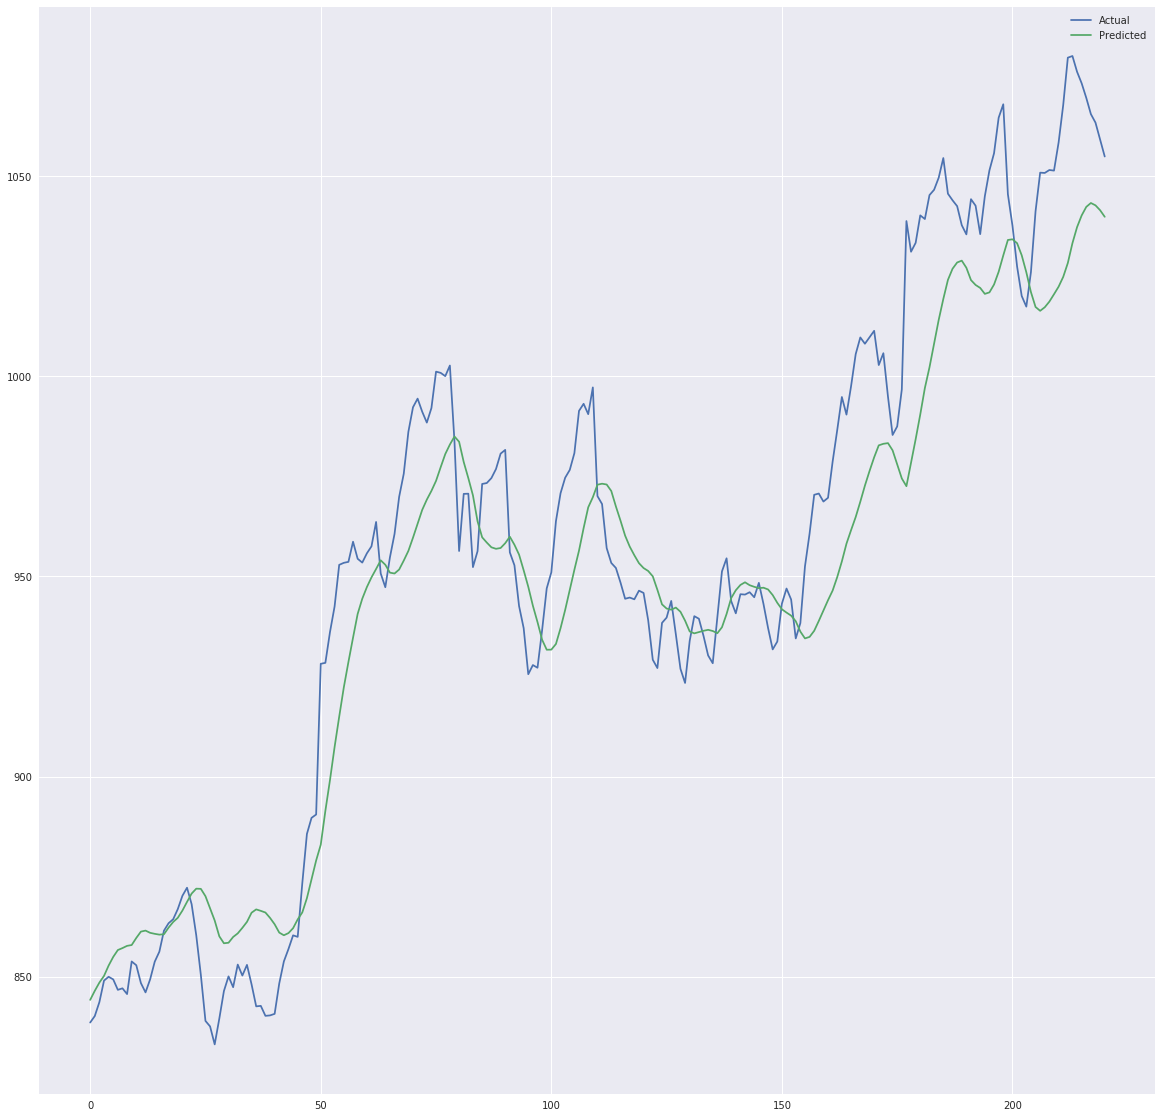

In [165]:
make_predictions(X_test, simple_model, scaler)

As we can see from the image above, although our model seems to have found some trend in the prices, it it _very_ far away from the actual stock value. Hence, this model cannot be used in a production environment.

**Question**: Can we improve this model?

Lets find out.

In [168]:
y_pred = simple_model.predict(X_test)
y_pred.shape


(221, 1)

<a id='dl'></a>
## Deep Neural Nets

As always, here is the solution to our problem

![DL](https://s14-eu5.ixquick.com/cgi-bin/serveimage?url=https%3A%2F%2Fmemegenerator.net%2Fimg%2Finstances%2F49099937%2Fwe-need-to-go-deeper.jpg&sp=820b593abca83c69cfd8fe7944c66fce)

Deep neural nets can capture trends over a largely spread dataset and could improve our model.
For this problem of forecasting, we will use a stacked LSTM(i.e multiple LSTM layers instead of 1). 
Further, we will also increase the number of units per LSTM cell to 50.

In [150]:
def create_dl_model():
    model = Sequential()

    # Adding the first LSTM layer
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 5)))

    # Adding a second LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))
    
    # Adding a third LSTM layer
    model.add(LSTM(units = 50, return_sequences = True))

    # Adding a fourth LSTM layer
    model.add(LSTM(units = 50))

    # Adding the output layer
    model.add(Dense(units = 1))
    return model

In [151]:
dl_model = create_dl_model()

In [152]:
dl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 50)            11200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 71,851
Trainable params: 71,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = compile_and_run(dl_model, epochs=30)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30


In [ ]:
plot_metrics(history)

As expected, we see that the overall loss of the model reducing until a minima is reached. After that, the loss just stays constant.

<a id='prediction_analysis'></a>
## Prediction Analysis

Let us try our deep neural net on the test set.

In [ ]:
make_predictions(X_test, dl_model, scaler)

As we can see, the deep neural net is a significant boost from our simple model. It has determined that the stock price is indeed related to the previous stock prices, and surprisngly, it is very accurate, so much so that at various points it is actually equal to the exact value of the stock on that day!

We could further improve this model by:

- **Deeper network** - Deep Neural Networks can learn relationships between data points seperated by a large time frame.
- **Dropout** - Adding a dropout layer would help prevent overfitting and stabalize the loss curves, which could give a better generalized model.
- **Training for longer** - Deep neural nets work better when they are trained for longer tend to work better. However, we must be careful not to overfit.
- **Adaptive Optimizers** - We could also use the Adam optimizer instead of SGD, which incorporates adaptive learning rates based on momentum. Adaptive optimizers should work better than SGD for this problem.
- **Hyper-parameter tuning** - Tuning the hyper-parameters is one of the simplest ways in which we can improve the network. We could use SGD with Restarts(part of the Fast.ai library) to help find the optimal learning rate, experiment with the number of units in each LSTM layer, etc.

<a id='conclusion'></a>
## Conclusion

In this notebook, we have acheived the following:
- Successfully analyzed the trends present in stock market prices of various companies and concluded that there is indeed a temporal relationship between these prices. 
- Devised a model capable of reliably forecasting the stock prices of a company, thereby providing a tool to maximize profits.
- Discussed possible implementation details to deploy such a model at scale and make it available to a larger number of people.

Please let me know about the areas where the solution could be improved. As always, please upvote the kernel if you find it useful. Cheers! :)